# Home Advantage in Football Matches

### Goal:
Analyze the dataset to determine if there is a measurable advantage for teams playing at home across different leagues and seasons. 
We'll explore trends across leagues and seasons, using data from the Kaggle Soccer dataset.


In [103]:
import kagglehub
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

In [104]:
path = kagglehub.dataset_download("hugomathien/soccer")
db_file = os.path.join(path, "database.sqlite")
try:
    conn = sqlite3.connect(db_file)
except sqlite3.OperationalError as e:
    print(f"Error: {e}")
    exit()

In [105]:
query = """
SELECT 
    home_team_goal, 
    away_team_goal, 
    league_id, 
    season, 
    home_team_api_id, 
    away_team_api_id
FROM Match
"""
matches = pd.read_sql(query, conn)
print(matches.head())

   home_team_goal  away_team_goal  league_id     season  home_team_api_id  \
0               1               1          1  2008/2009              9987   
1               0               0          1  2008/2009             10000   
2               0               3          1  2008/2009              9984   
3               5               0          1  2008/2009              9991   
4               1               3          1  2008/2009              7947   

   away_team_api_id  
0              9993  
1              9994  
2              8635  
3              9998  
4              9985  


# Exploratory Data Analysis (EDA)
This section focuses on understanding key patterns and distributions within the dataset. The goal of the EDA is to uncover insights into match outcomes, scoring trends, and team performances. By visualizing and summarizing the data, we aim to answer the following questions:

1. **Goal Distribution**:
   - How are goals distributed for home and away teams?
   - Is there a noticeable difference between home and away performances?

2. **Match Outcomes**:
   - What percentage of matches result in home wins, draws, and losses?
   - Is there evidence of a home-field advantage?

3. **Comparisons and Trends**:
   - How do home and away team goals compare side by side?
   - Are there correlations or patterns that might indicate influencing factors?

Through visualizations (e.g., histograms, count plots) and statistical summaries, this section will provide an in-depth look into the dataset’s structure and key characteristics. These findings will form the foundation for more advanced analysis in subsequent sections.

## Distribution of Home Team Goals


Average Home Goals: 1.5445937103044767


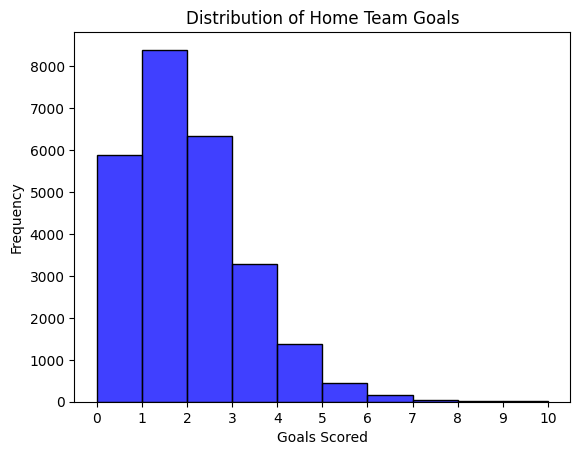

In [106]:
queryHomeGoals = """
SELECT home_team_goal 
FROM Match
"""
home_goals = pd.read_sql(queryHomeGoals, conn)
home_avg_goals = matches['home_team_goal'].mean()
print(f"\nAverage Home Goals: {home_avg_goals}")
sns.histplot(home_goals['home_team_goal'], color="blue", bins=10)
plt.xticks(range(0, 11, 1))
plt.title("Distribution of Home Team Goals")
plt.xlabel("Goals Scored")
plt.ylabel("Frequency")
plt.show()

The histogram shows the distribution of goals scored by home teams with the large majority between 0-3 goals, with a mean of 1.54 goals per match and a peak at 1 goal per match. There are a few instances of higher goal counts (5+ goals) indicating that high-scoring games are rare, and providing a graph that is skewed right.

## Distribution of Away Team Goals

Average Away Goals: 1.1609376804341969


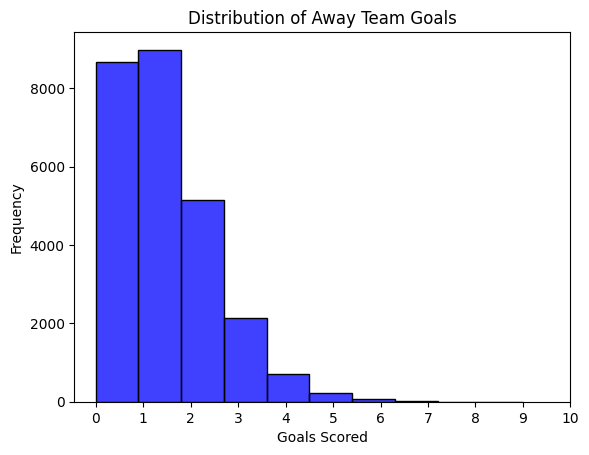

In [107]:
queryAwayGoals = """
SELECT away_team_goal 
FROM Match
"""
away_goals = pd.read_sql(queryAwayGoals, conn)
away_avg_goals = matches['away_team_goal'].mean()
print(f"Average Away Goals: {away_avg_goals}")
sns.histplot(away_goals['away_team_goal'], color="blue", bins=10)
plt.xticks(range(0, 11, 1))
plt.title("Distribution of Away Team Goals")
plt.xlabel("Goals Scored")
plt.ylabel("Frequency")
plt.show()

Away teams scored fewer goals on average compared to home teams. The histogram indicates that most away teams scored 0-2 goals per match with two almost equal peaks at 0 and 1. This gives the average goals per match for an away team as 1.16. This trend highlights the home advantage in football. 

## Distribution of Home Match Outcomes


Match Outcome Percentages:
result
Win     45.871666
Loss    28.738597
Draw    25.389738
Name: proportion, dtype: float64


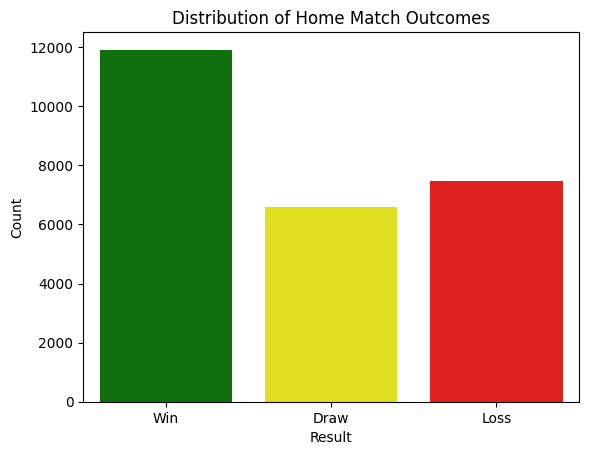

In [108]:
matches['result'] = matches.apply(
    lambda row: 'Win' if row['home_team_goal'] > row['away_team_goal']
    else 'Loss' if row['home_team_goal'] < row['away_team_goal']
    else 'Draw', axis=1
)
result_counts = matches['result'].value_counts(normalize=True) * 100
print("\nMatch Outcome Percentages:")
print(result_counts)
custom_palette = {
    "Win": "green",
    "Draw": "yellow",
    "Loss": "red"
}
sns.countplot(data=matches, x='result', hue='result', order=['Win', 'Draw', 'Loss'], 
              palette=custom_palette, dodge=False, legend=False)
plt.title("Distribution of Home Match Outcomes")
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()

The match outcomes reveal that home teams win 45.87% of matches, with draws occurring 25.39% of the time and losses at 28.74%. This supports the observation that home teams tend to have an advantage.

## Boxplot Comparison

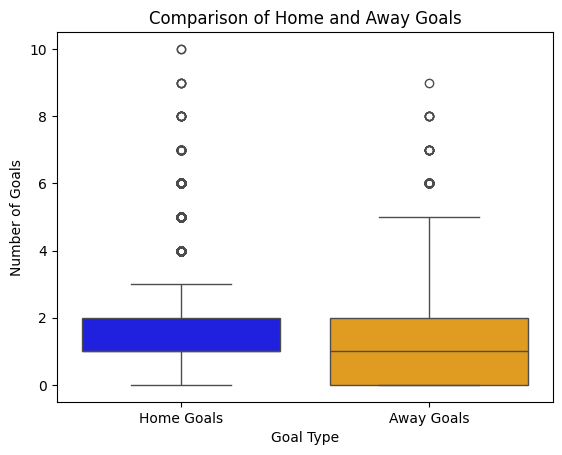

In [109]:
goals_data = pd.melt(matches[['home_team_goal', 'away_team_goal']], 
                     var_name='Goal Type', 
                     value_name='Goals',
                     value_vars=['home_team_goal', 'away_team_goal'])

goals_data['Goal Type'] = goals_data['Goal Type'].replace({
    'home_team_goal': 'Home Goals',
    'away_team_goal': 'Away Goals'
})

sns.boxplot(data=goals_data, x='Goal Type', y='Goals', palette=['blue', 'orange'], hue='Goal Type')
plt.title("Comparison of Home and Away Goals")
plt.xlabel("Goal Type")
plt.ylabel("Number of Goals")
plt.show()

The median of home goals is slightly higher compared to away goals, suggesting teams tend to score more at home on average. The interquartile range for home goals is relatively compact, indicating less variation in home goal scores. It is slightly larger for away goals however. There quite a lot of outliers with matches with 4-10 goals for both home and away. 

## Distribution of Match Results By League

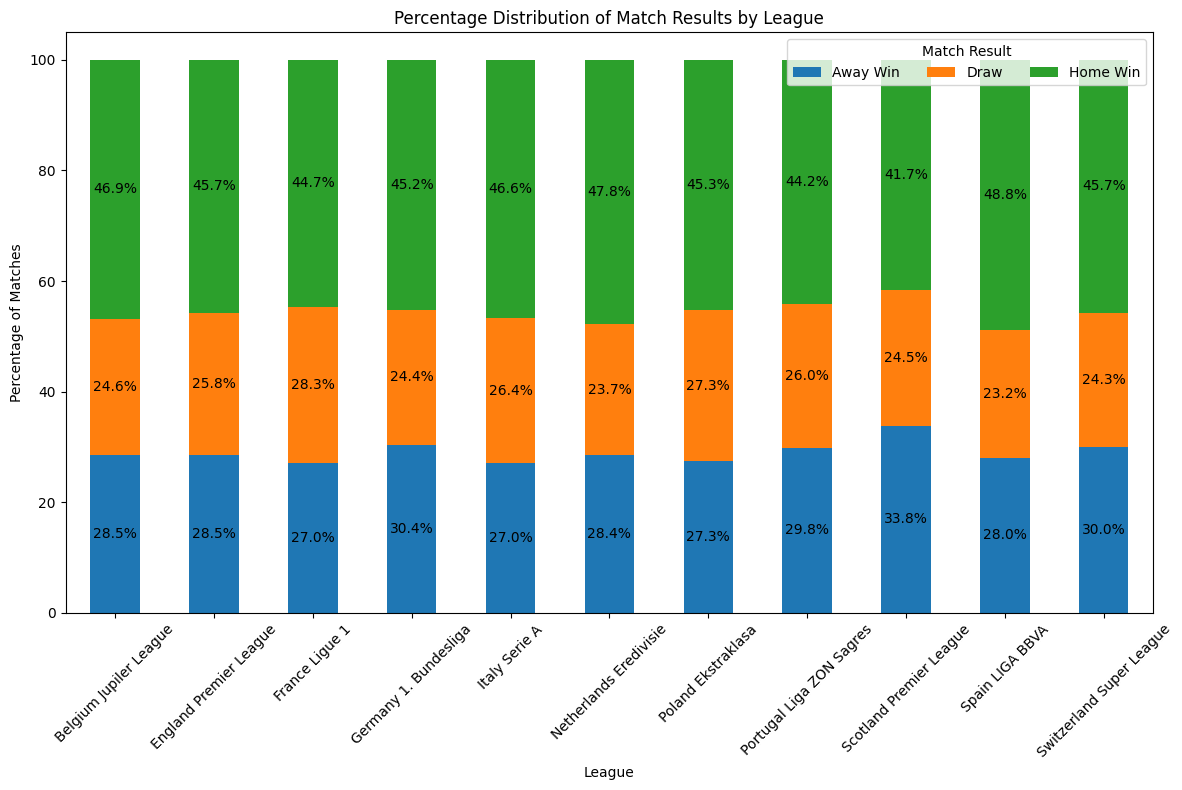

In [131]:
queryResults = """
SELECT 
    m.league_id, 
    m.home_team_goal, 
    m.away_team_goal, 
    l.name
FROM Match m
JOIN League l ON m.league_id = l.id
"""
matches_results = pd.read_sql(queryResults, conn)
def classify_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'Home Win'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'Away Win'
    else:
        return 'Draw'
matches_results['result'] = matches_results.apply(classify_result, axis=1)
result_distribution = matches_results.groupby(['name', 'result']).size().unstack(fill_value=0)
result_distribution_percentage = result_distribution.div(result_distribution.sum(axis=1), axis=0) * 100
ax = result_distribution_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Percentage Distribution of Match Results by League")
plt.xlabel("League")
plt.ylabel("Percentage of Matches")
plt.xticks(rotation=45)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    result_percentage = height
    if result_percentage > 0:
        ax.annotate(f'{result_percentage:.1f}%', 
                    (x, y), 
                    color='black', 
                    ha='center', 
                    va='center')
plt.legend(title="Match Result",ncol=3)
plt.tight_layout()
plt.show()
